In [1]:
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


In [2]:
import surp
from surp import gce_math as gcem
import arya

from surp import subgiants

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
data_dir = surp._globals.DATA_DIR

In [4]:
def keil_plot(teff, logg, bins=None, **kwargs):
    if bins is None:
        bins = 200
        xbins = np.linspace(np.nanmin(teff), np.nanmax(teff), bins)
        ybins = np.linspace(np.nanmin(logg), np.nanmax(logg), bins)
        
    plt.scatter(teff, logg, **kwargs)

    ax = plt.gca()
    if not ax.xaxis_inverted():
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
    plt.xlabel(r"$T_{\rm eff}$ / K")
    plt.ylabel(r"$\log g$")

In [5]:
def plot_ab(df, x, y, **kwargs):
    plt.scatter(df[x], df[y], **kwargs)
    #arya.plotting.medianplot(df, x, y, numbins=25, color="k")
    plt.xlabel(to_nice_name(x))
    plt.ylabel(to_nice_name(y))

In [6]:
def to_nice_name(apogee_name):
    name = apogee_name.replace("_", "/").title()
    name = f"[{name}]"
    return name

# Hypatia

In [7]:
hypatia = Table.read(data_dir + "hypatia.fits", format="fits")

hypatia_new = pd.read_csv(data_dir + "hypatia-20052024.csv")

In [8]:
hypatia_new

,f_preferred_name,Fe,Fe_err,C,C_err,O,O_err,Mg,Mg_err,Si,...,f_vmag,f_bv,f_u,f_v,f_w,f_teff,f_logg,f_mass,f_radius,Unnamed: 34
0,HIP 32768,0.02,0.04,-0.14,0.09,-0.06,0.09,0.21,0.07,0.27,...,2.94,1.207,12.7,-36.2,-8.7,4710.0,1.74,NaN,NaN,NaN
1,HIP 65536,-1.00,0.04,-0.72,0.09,-0.35,0.09,-0.60,0.07,-0.80,...,5.82,1.652,56.7,-18.3,-30.4,3959.5,NaN,NaN,72.25,NaN
2,HIP 98314,-0.34,0.04,-0.45,0.14,-0.24,0.14,-0.12,0.06,-0.22,...,6.77,0.902,28.6,47.5,-14.9,4983.0,3.02,NaN,5.74,NaN
3,HIP 98316,-0.07,0.06,-0.07,0.09,NaN,NaN,0.02,0.10,-0.02,...,8.54,1.050,NaN,NaN,NaN,4746.9,4.49,0.76,0.75,NaN
4,HIP 65550,-0.04,0.04,-0.26,0.04,-0.07,0.06,-0.06,0.07,0.06,...,5.88,0.985,20.7,4.4,6.1,4881.0,2.54,NaN,10.68,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8863,2MASS 08130018+0447132,0.23,0.10,NaN,NaN,NaN,NaN,0.09,0.07,0.13,...,NaN,NaN,NaN,NaN,NaN,6288.5,4.40,1.18,1.36,NaN
8864,2MASS 19220395+4305017,0.21,0.04,0.08,0.09,-0.05,0.09,0.15,0.07,0.12,...,NaN,NaN,NaN,NaN,NaN,4940.0,4.53,0.83,0.80,NaN
8865,HIP 65530,0.25,0.11,0.38,0.09,0.02,0.09,0.27,0.02,0.23,...,6.50,0.739,-35.2,-26.6,-32.5,5578.0,4.41,0.99,1.05,NaN
8866,HIP 32765,-0.10,0.06,-0.02,0.09,-0.02,0.12,-0.13,0.03,-0.18,...,5.14,0.460,-47.0,-13.6,6.8,6446.5,4.10,1.32,1.68,NaN


In [9]:
filt = hypatia_new.f_logg >= 3.5
filt &= ~np.isnan(hypatia_new.C)
filt &= ~np.isnan(hypatia_new.Mg)

hypatia_clean = hypatia_new[filt].copy()

In [42]:
hypatia_clean["C_MG"] = hypatia_clean.C - hypatia_clean.Mg
hypatia_clean["C_O"] = hypatia_clean.C - hypatia_clean.O

hypatia_clean["MG_H"] = hypatia_clean.Mg
hypatia_clean["O_H"] = hypatia_clean.O

hypatia_clean["MG_FE"] = hypatia_clean.Mg - hypatia_clean.Fe

hypatia_clean["FE_H"] = hypatia_clean.Fe
hypatia_clean["O_MG"] = hypatia_clean.O - hypatia_clean.Mg
hypatia_clean["O_FE"] = hypatia_clean.O - hypatia_clean.Fe

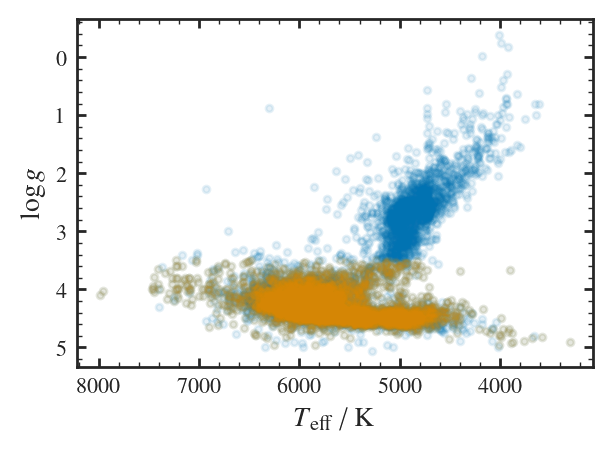

In [11]:
keil_plot(hypatia_new.f_teff, hypatia_new.f_logg,alpha=0.1)
keil_plot(hypatia_clean.f_teff, hypatia_clean.f_logg,alpha=0.1)


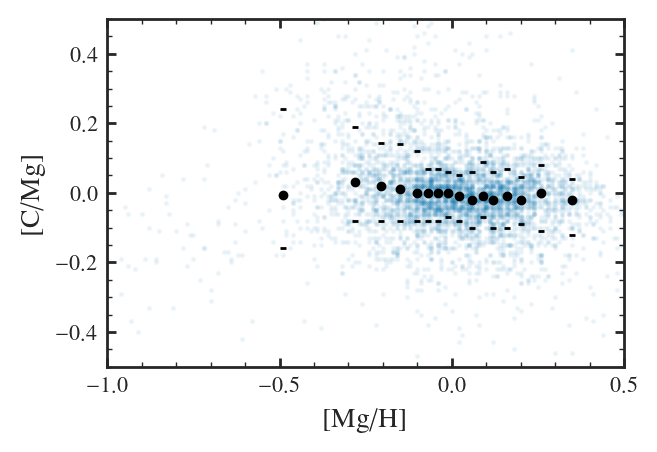

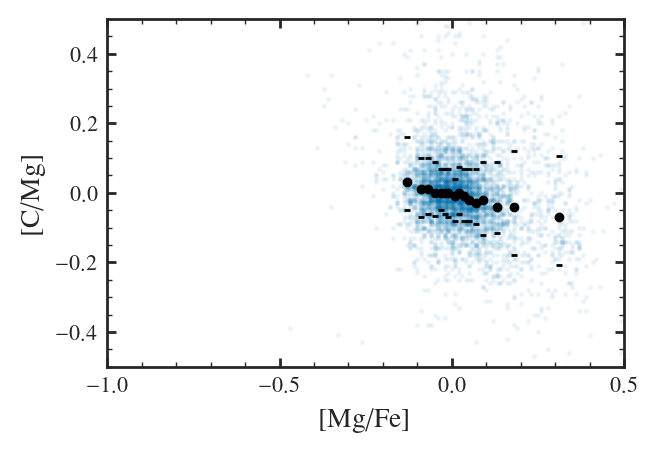

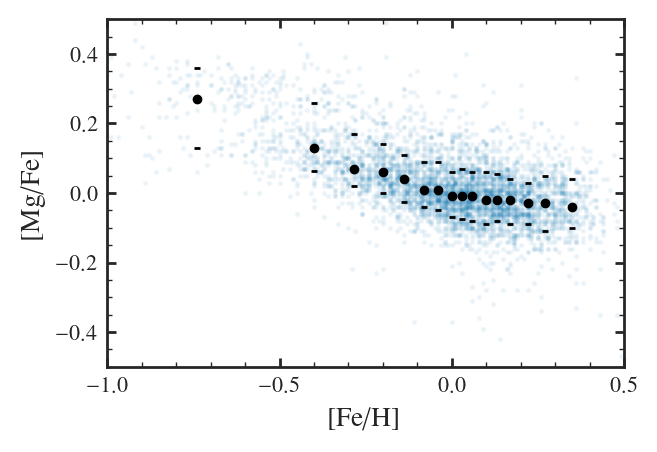

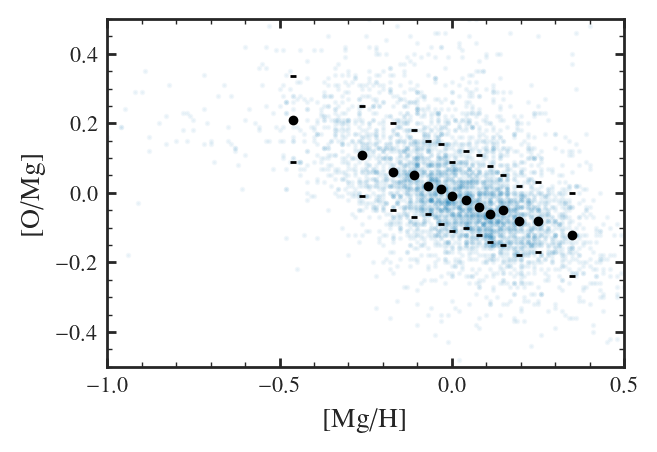

In [12]:
for ele1, ele2 in [("MG_H", "C_MG"), ("MG_FE", "C_MG"), ("FE_H", "MG_FE"), ( "MG_H", "O_MG",)]:
    plot_ab(hypatia_clean, ele1, ele2, alpha=0.05, s=1)
    arya.medianplot(hypatia_clean, ele1, ele2, color="k", binsize=300)
    plt.xlim(-1, 0.5)
    plt.ylim(-0.5, 0.5)
    plt.show()

# Luck 2018

In [13]:
luck18 = Table.read(data_dir + "luck2018.fits", format="fits")
luck18 = luck18.to_pandas()

Some important columns
- C538.2: Log carbon abundance from C I 538.2 nm line
- C2: Log carbon abundance from C2 Swan lines (primary indicator at 513.5 nm)
- O615.5:  Log oxygen abundance from O I 615.5 nm triplet
- O630.0:  Log oxygen abundance from [O I] 630.0 nm line

use Cmean and Omean for 12 + log abund

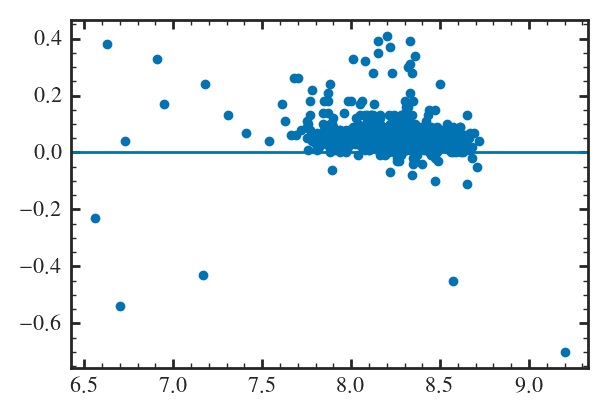

In [14]:
plt.scatter(luck18["C505_2"], luck18.C538_2 - luck18.C505_2)
plt.axhline(0)

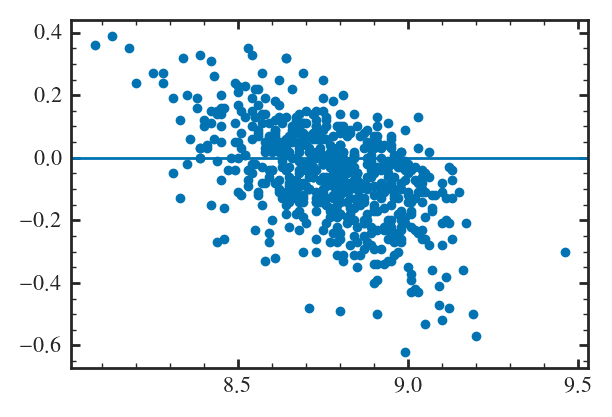

In [15]:
plt.scatter(luck18["O615_5"], luck18.O630_0 - luck18.O615_5)
plt.axhline(0)

In [16]:
luck18["C_H"] = gcem.eps_to_brak(luck18["Cmean"], "C")
luck18["O_H"] = gcem.eps_to_brak(luck18["Omean"], "o")

luck18["C_O"] = luck18.C_H - luck18.O_H

luck18["FE_H"] = luck18["__Fe_H_"]
luck18["O_FE"] = luck18.O_H - luck18.FE_H


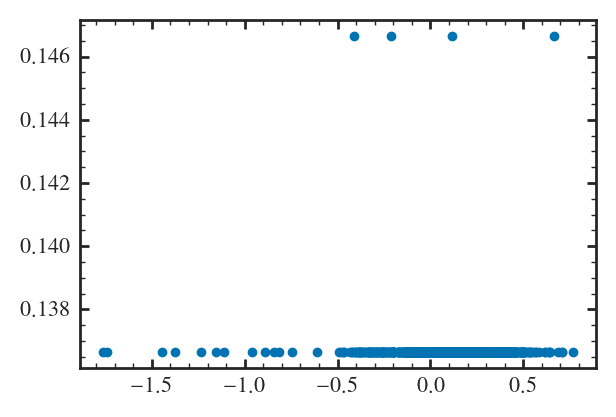

In [17]:
plt.scatter(luck18.C_H, luck18.C_H - luck18["__C_H_mean"])

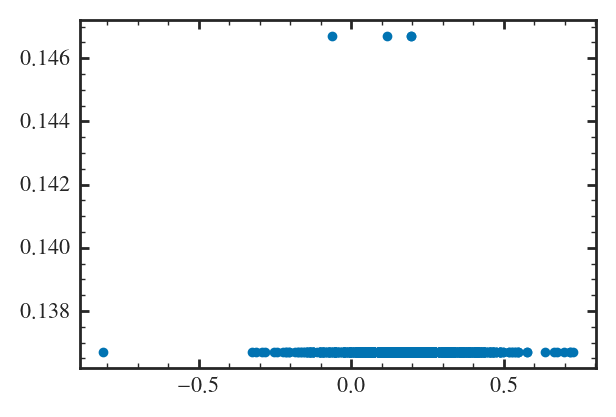

In [18]:
plt.scatter(luck18.O_H, luck18.O_H - luck18["__O_H_mean"])

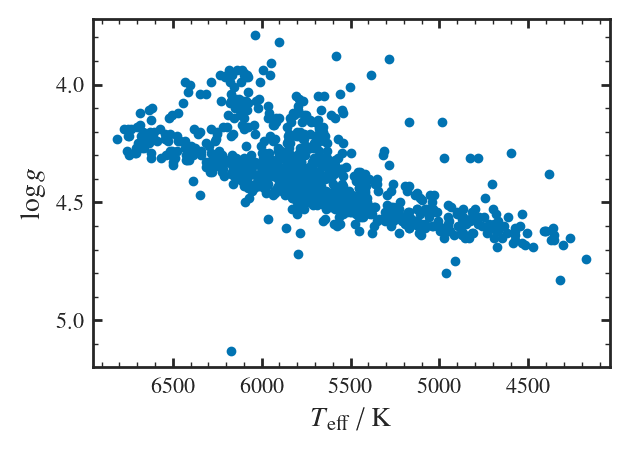

In [19]:
keil_plot(luck18.Teff, luck18.logg)

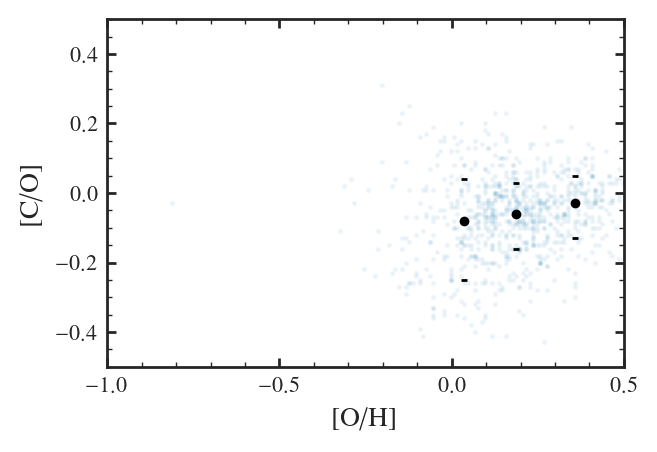

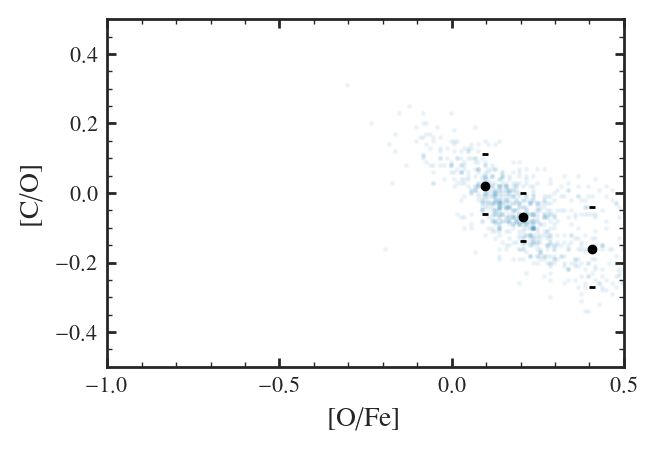

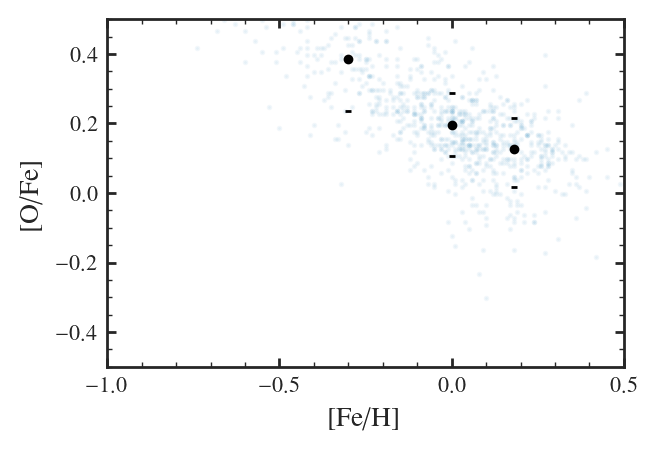

In [20]:
for ele1, ele2 in [("O_H", "C_O"), ("O_FE", "C_O"), ("FE_H", "O_FE")]:
    plot_ab(luck18, ele1, ele2, alpha=0.05, s=1)
    arya.medianplot(luck18, ele1, ele2, color="k", binsize=300)
    plt.xlim(-1, 0.5)
    plt.ylim(-0.5, 0.5)
    plt.show()

# HARPS GTO

Uses the high resolution HARPS-GTO spectrograph (R ~ 115 000).
Determines C from two atomic lines using LTE EW analysis.

- Wavelength range: 3770–6900
- SNR > 100 or > 300 
- C from 5052 Å and 5380

Oxygen was derived in Bertran de Lis et al. (2015, https://ui.adsabs.harvard.edu/abs/2015A%26A...576A..89B/abstract) from [O I] at 6158 and OI at 6300, which are labeled at O1 and O2 respectively.

In [21]:
harps = Table.read(data_dir + "harps_gto.fits", format="fits")
harps = harps.to_pandas()

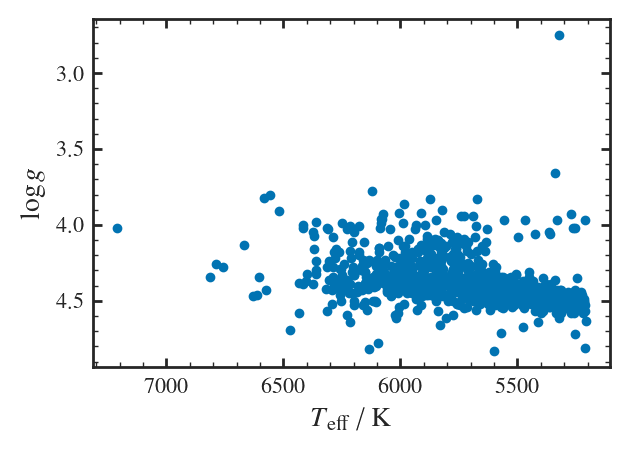

In [22]:
keil_plot(harps.Teff, harps.logg)

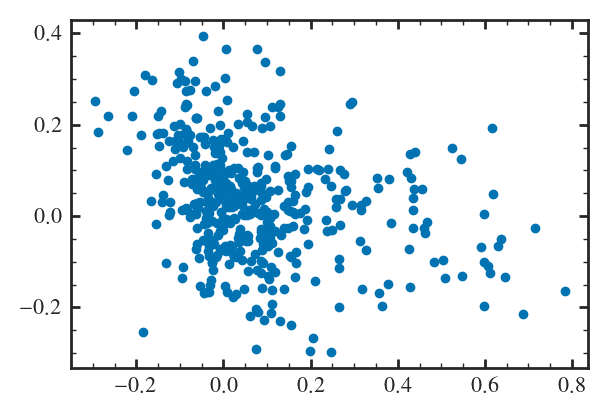

In [23]:
plt.scatter(harps.__O1_Fe_, harps.__O2_Fe_ - harps.__O1_Fe_)

In [24]:
harps["FE_H"] = harps.__Fe_H_
harps["O_FE"] = np.nanmean([harps.__O1_Fe_, harps.__O2_Fe_], axis=0)
harps["O_H"] = harps.O_FE + harps.FE_H

harps["C_O"] = harps["__C_Fe_"] - harps.O_FE

/tmp/slurmtmp.28788443/ipykernel_57140/3465269444.py:2: RuntimeWarning: Mean of empty slice
  harps["O_FE"] = np.nanmean([harps.__O1_Fe_, harps.__O2_Fe_], axis=0)


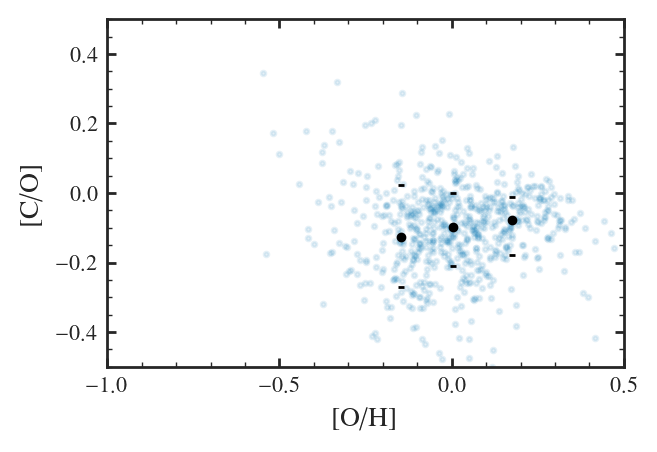

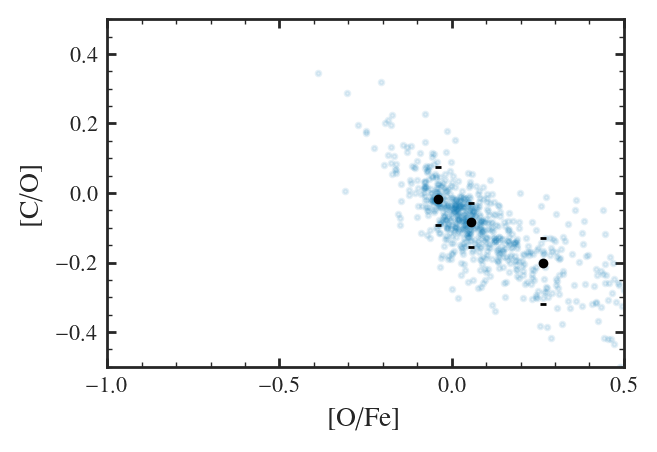

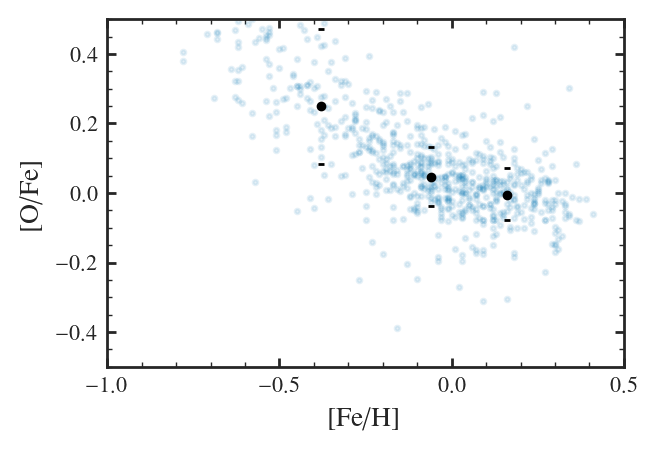

In [25]:
for ele1, ele2 in [("O_H", "C_O"), ("O_FE", "C_O"), ("FE_H", "O_FE")]:
    plot_ab(harps, ele1, ele2, alpha=0.1, s=3)
    arya.medianplot(harps, ele1, ele2, color="k", binsize=300)
    plt.xlim(-1, 0.5)
    plt.ylim(-0.5, 0.5)
    plt.show()

# HARPS CH
Also there is another study using HARPS GTO but with CH
https://ui.adsabs.harvard.edu/abs/2017A%26A...599A..96S/abstract
TODO: Need to combine with other data...

In [26]:
harps_ch = Table.read(data_dir + "harps_ch.fits", format="fits")


In [27]:

harps_ch

PapI,Name,Teff,logg,__Fe_H_,vtur,__C_H_,e__C_H_,popB,SimbadName,_RA,_DE,recno
,,K,log(cm.s**-2),,km / s,,,,,deg,deg,
bytes4,bytes10,int16,float32,float32,float32,float32,float32,bytes5,bytes10,float64,float64,int32
PapI,BD+062932,5272,4.43,-0.84,0.06,-1.1100,0.12,halo,BD+062932,220.82488,5.82771,1
PapI,BD+063077,6136,4.95,-0.36,1.07,-0.3300,0.15,thick,BD+063077,234.66255,6.37512,2
PapI,BD+083095,5728,4.12,-0.77,0.85,-0.7600,0.20,trans,BD+083095,237.74555,8.42326,3
PapI,BD-002387,4833,4.47,0.03,0.85,-0.1800,0.13,thin,BD-002387,163.76762,-0.80524,4
PapI,BD-010184,4728,4.34,-0.34,0.40,-0.4200,0.13,thin,BD-010184,21.28954,-1.05968,5
PapI,BD-012505,4741,4.51,-0.11,0.44,-0.3700,0.16,thin,BD-012505,169.30694,-1.98185,6
PapI,BD-033746,4732,4.63,-0.90,0.15,-0.8500,0.17,thick,BD-033746,228.49851,-3.79800,7
PapI,BD-034797,4622,4.21,0.06,0.30,-0.2000,0.22,thin,BD-034797,302.42089,-3.12901,8


# Brewer + 2016

using HIRIS (R≈70,000).
LTE assumed. Our line list contains 63 atomic carbon lines; typically, these are shallow or blended

In [28]:
brewer16 = Table.read(data_dir + "brewer+2016.fits", format="fits")
brewer16 = brewer16.to_pandas()

In [29]:
brewer16.columns.to_list()

['recno',
 'SPOCS',
 'Name',
 'Teff',
 'logg',
 '__M_H_',
 'S',
 'logRhk',
 'Vbr',
 'Vsini',
 'Vmac',
 'Vrad',
 'SNR',
 'Crms',
 'Lrms',
 'N',
 '__C_H_',
 '__N_H_',
 '__O_H_',
 '__Na_H_',
 '__Mg_H_',
 '__Al_H_',
 '__Si_H_',
 '__Ca_H_',
 '__Ti_H_',
 '__V_H_',
 '__Cr_H_',
 '__Mn_H_',
 '__Fe_H_',
 '__Ni_H_',
 '__Y_H_',
 'RAJ2000',
 'DEJ2000',
 'Vmag',
 'Dist',
 'logL',
 'e_logL',
 'Rstar',
 'e_Rstar',
 'Mstar',
 'e_Mstar',
 'Miso',
 'b_Miso',
 'b_miso_lc',
 'logg2',
 'e_logg2',
 'Age',
 'b_Age',
 'b_age_lc',
 'CCat',
 'Simbad']

In [43]:
brewer16["C_H"] = brewer16.__C_H_
brewer16["O_H"] = brewer16.__O_H_
brewer16["FE_H"] = brewer16.__Fe_H_
brewer16["MG_H"] = brewer16.__Mg_H_


brewer16["C_MG"] = brewer16.C_H - brewer16.MG_H
brewer16["MG_FE"] = brewer16.MG_H - brewer16.FE_H
brewer16["O_MG"] = brewer16.O_H - brewer16.MG_H

brewer16["C_O"] = brewer16.C_H - brewer16.O_H
brewer16["O_FE"] = brewer16.O_H - brewer16.FE_H


In [45]:
filt = brewer16.logg > 3.5

brewer16_clean = brewer16[filt].copy()

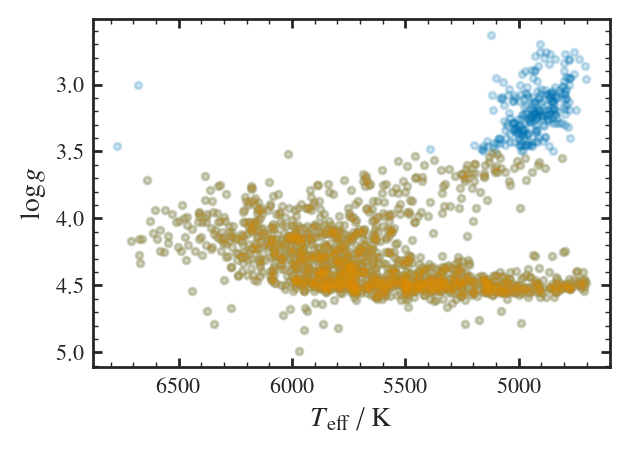

In [46]:
keil_plot(brewer16.Teff, brewer16.logg, alpha=0.2)
keil_plot(brewer16_clean.Teff, brewer16_clean.logg, alpha=0.2)

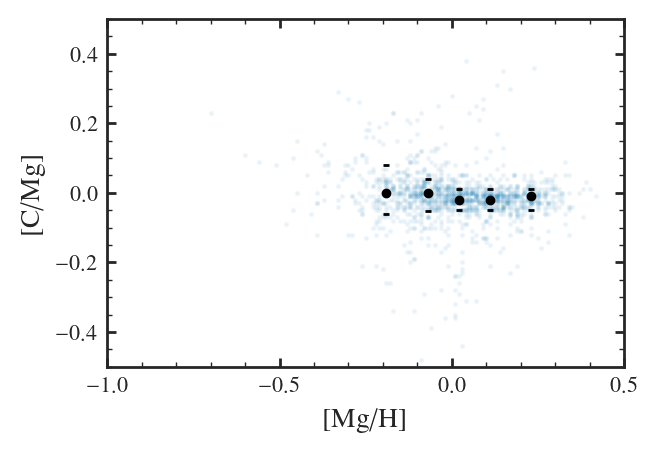

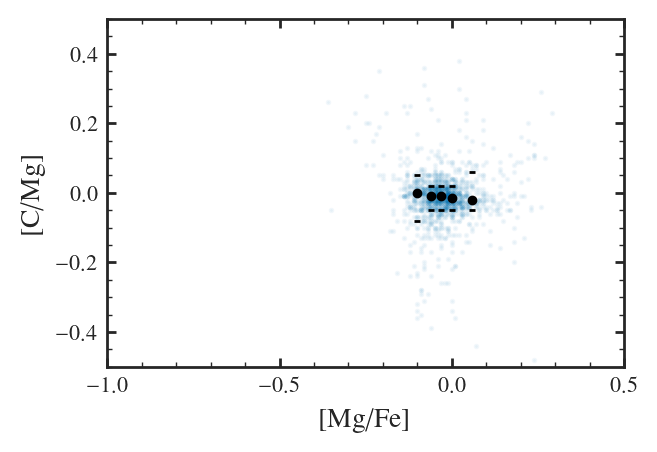

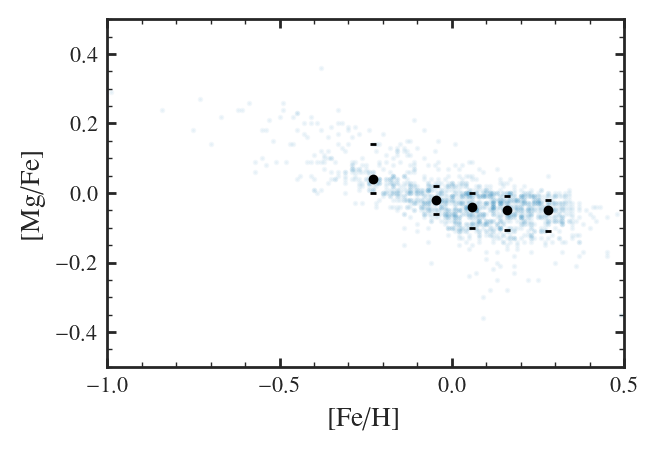

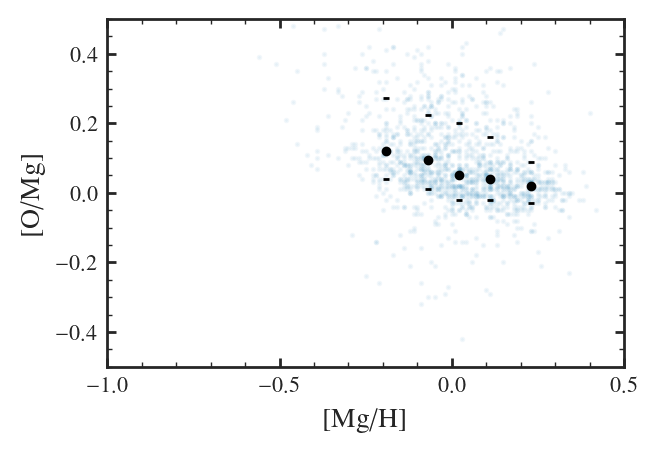

In [33]:
for ele1, ele2 in [("MG_H", "C_MG"), ("MG_FE", "C_MG"), ("FE_H", "MG_FE"), ( "MG_H", "O_MG",)]:
    plot_ab(brewer16_clean, ele1, ele2, alpha=0.05, s=1)
    arya.medianplot(brewer16_clean, ele1, ele2, color="k", binsize=300)
    plt.xlim(-1, 0.5)
    plt.ylim(-0.5, 0.5)
    plt.show()

# ALL

In [92]:
hypatia_clean.plot_kwargs = dict(
    color=arya.COLORS[1],
    binsize=300,
    label="hypatia",
    marker="s"
)

In [93]:
brewer16_clean.plot_kwargs = dict(
    color=arya.COLORS[2],
    binsize=100,
    label="brewer"
)

In [94]:
harps.plot_kwargs = dict(
    color=arya.COLORS[3],
    binsize=100,
    label="harps",
    marker="o"
)

In [95]:
luck18.plot_kwargs = dict(
    color=arya.COLORS[4],
    binsize=100,
    label="luck",
    marker="*"
)

In [96]:
studies = {
    "hypatia": hypatia_clean,
    "brewer+16": brewer16_clean,
    "harps-GTO": harps,
    "luck18": luck18
}

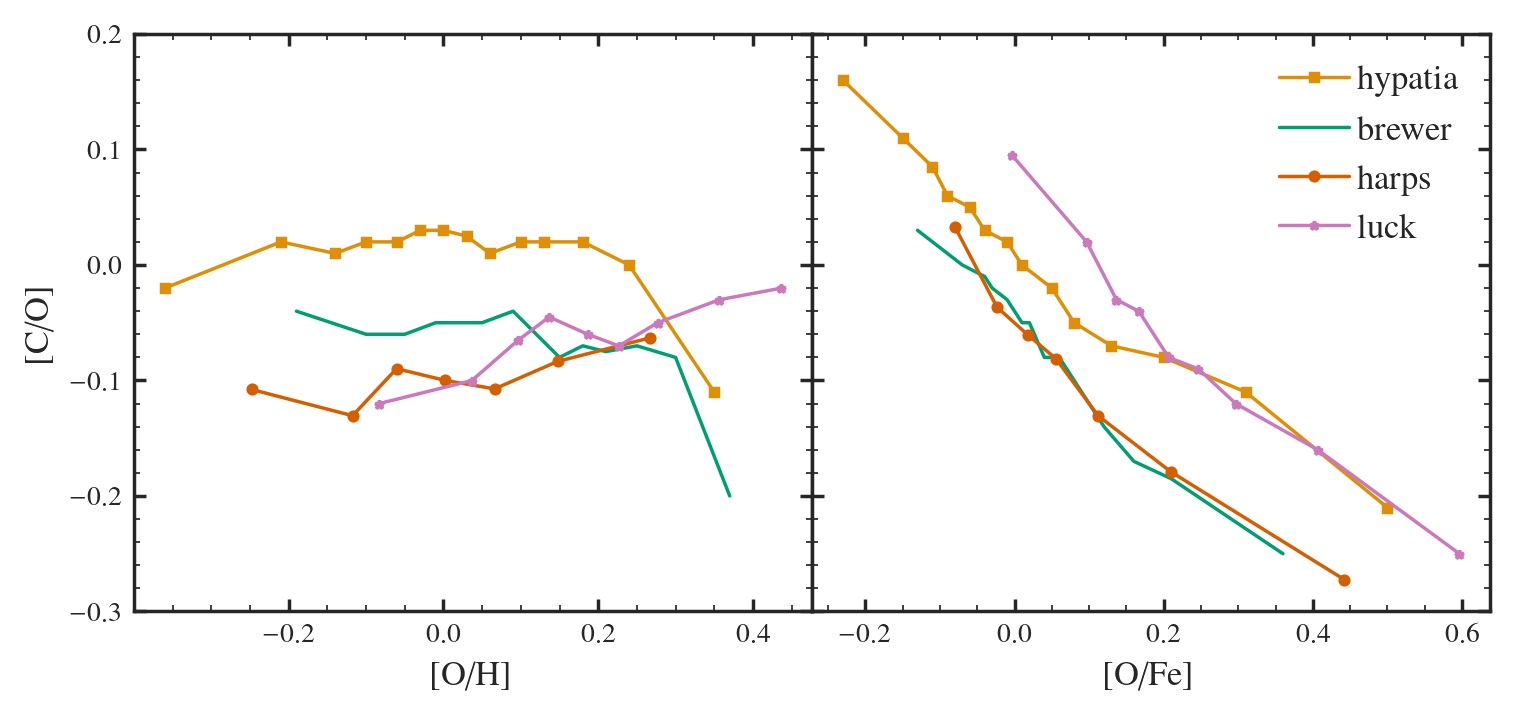

In [102]:

fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharey=True, gridspec_kw={"wspace": 0}, dpi=250)

plt.sca(axs[0])
x = "O_H"
y = "C_O"

i = 0

for key, study in studies.items():
    study = studies[key]
    arya.medianplot(study, x, y, aes="line", errorbar=None, **study.plot_kwargs)


plt.ylim(-0.25)

plt.xlabel("[O/H]")
plt.ylabel("[C/O]")

plt.sca(axs[1])

x = "O_FE"
y = "C_O"

i = 0

for key, study in studies.items():
    study = studies[key]
    arya.medianplot(study, x, y, aes="line", errorbar=None, **study.plot_kwargs)


plt.ylim(-0.3, 0.2)

arya.Legend()
plt.xlabel("[O/Fe]")

plt.savefig("caah_catalogues.pdf")